In [53]:
import numpy as np
import json
import gzip
import random
import matplotlib.pyplot as plt
from collections import defaultdict
from datetime import datetime
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression, Ridge
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error, accuracy_score, f1_score, confusion_matrix
from sklearn.preprocessing import OneHotEncoder
from sklearn.decomposition import TruncatedSVD
from scipy.sparse import hstack

In [46]:
def parse(path):
  with gzip.open(path, 'rt') as g:
      for l in g:
          yield json.loads(l)

# loads in metadata
metadata = {
    m['gmap_id']: {
        'category': m.get('category', 'Unknown'),
        'price': m.get('price', 'Unknown')
    }
    for m in parse("meta-California.json.gz")
}

# load reviews and merge metadata
# sample 200k
sample_size = 200000
reviews = []
for r in parse("review-California_10.json.gz"):
    if r['gmap_id'] in metadata:
        r.update(metadata[r['gmap_id']])
        
        # Ensure text is not None
        if not r.get('text'):
            r['text'] = ""
        reviews.append(r)
    
    if len(reviews) >= sample_size:
        break

# convert timestamps to datetime so that we can train/test split later
for r in reviews:
    r['time'] = datetime.fromtimestamp(r['time']/1000)

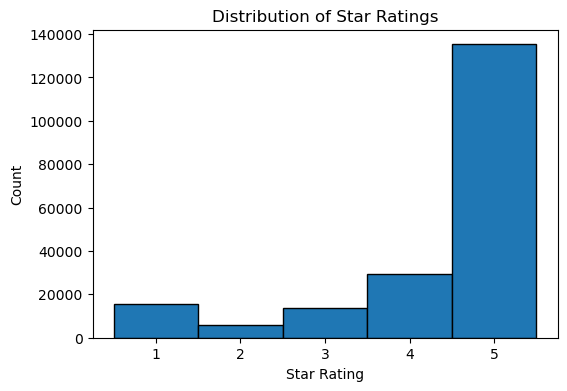

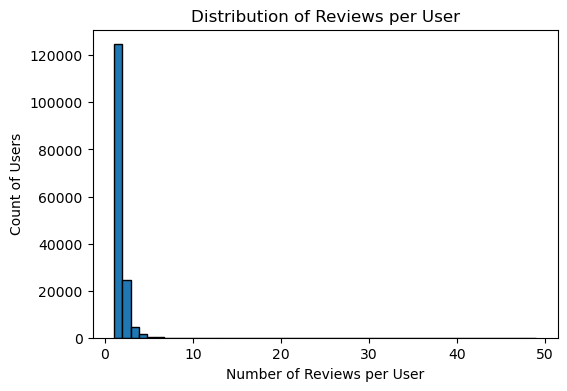

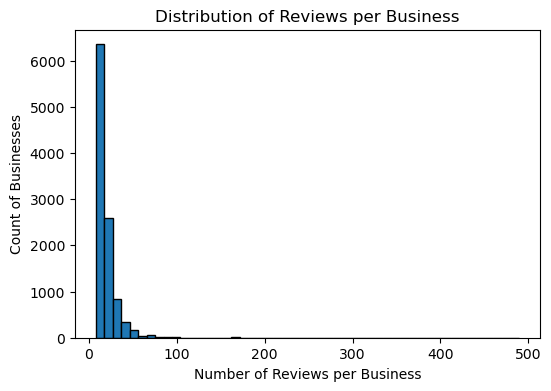

In [47]:
# distribution of star ratings
ratings = [r['rating'] for r in reviews]
plt.figure(figsize=(6,4))
plt.hist(ratings, bins=np.arange(1,7)-0.5, edgecolor='black')
plt.xlabel("Star Rating")
plt.ylabel("Count")
plt.title("Distribution of Star Ratings")
plt.xticks([1,2,3,4,5])
plt.show()

# reviews per user
userCounts = defaultdict(int)
for r in reviews:
    userCounts[r['user_id']] += 1

plt.figure(figsize=(6,4))
plt.hist(list(userCounts.values()), bins=50, edgecolor='black')
plt.xlabel("Number of Reviews per User")
plt.ylabel("Count of Users")
plt.title("Distribution of Reviews per User")
plt.show()

# reviews per business
businessCounts = defaultdict(int)
for r in reviews:
    businessCounts[r['gmap_id']] += 1

plt.figure(figsize=(6,4))
plt.hist(list(businessCounts.values()), bins=50, edgecolor='black')
plt.xlabel("Number of Reviews per Business")
plt.ylabel("Count of Businesses")
plt.title("Distribution of Reviews per Business")
plt.show()

In [48]:
# sort reviews by timestamp to train on old and test on new
sortedReviews = sorted(reviews, key=lambda r: r['time'])
splitIndex = int(0.9 * len(sortedReviews))
trainReviews = sortedReviews[:splitIndex]
testReviews = sortedReviews[splitIndex:]

# Extract rating and text
y_train = [r['rating'] for r in trainReviews]
y_test = [r['rating'] for r in testReviews]

trainTexts = [r['text'] if r['text'] else '' for r in trainReviews]
testTexts = [r['text'] if r['text'] else '' for r in testReviews]

In [51]:
modeRating = max(set(y_train), key=y_train.count)

# business average baseline 
businessSum = {}
businessCount = {}
for r in trainReviews:
    b = r['gmap_id']
    s = r['rating']
    businessSum[b] = businessSum.get(b,0) + s
    businessCount[b] = businessCount.get(b,0) + 1
businessAvg = {b: businessSum[b]/businessCount[b] for b in businessSum}
businessPreds = [businessAvg.get(r['gmap_id'], modeRating) for r in testReviews]
roundedBusinessPred = [int(round(p)) for p in businessPreds]

# user average baseline
userSum = {}
userCount = {}
for r in trainReviews:
    u = r['user_id']
    s = r['rating']
    userSum[u] = userSum.get(u,0) + s
    userCount[u] = userCount.get(u,0) + 1
userAvg = {u: userSum[u]/userCount[u] for u in userSum}
userPreds = [userAvg.get(r['user_id'], modeRating) for r in testReviews]
roundedUserPred = [int(round(p)) for p in userPreds]

# TF-IDF + logsitic regression baseline
vectorizer = TfidfVectorizer(max_features=10000, lowercase=True, sublinear_tf=True)
xTrainVec = vectorizer.fit_transform(trainTexts)
xTestVec = vectorizer.transform(testTexts)

lr = LogisticRegression(max_iter=5000)
lr.fit(xTrainVec, y_train)
y_pred_lr = lr.predict(xTestVec)

In [52]:
def evaluate(y_true, y_pred, name="Model"):
    acc = accuracy_score(y_true, y_pred)
    f1 = f1_score(y_true, y_pred, average='weighted')
    mae = mean_absolute_error(y_true, y_pred)
    cm = confusion_matrix(y_true, y_pred)
    print(f"--- {name} ---")
    print("Accuracy:", acc)
    print("Weighted F1:", f1)
    print("Mean Absolute Error:", mae)
    print("Confusion Matrix:\n", cm)
    print("\n")

evaluate(y_test, roundedBusinessPred, "Business Average Baseline")
evaluate(y_test, roundedUserPred, "User Average Baseline")
evaluate(y_test, y_pred_lr, "TF-IDF + Logistic Regression")

--- Business Average Baseline ---
Accuracy: 0.5029
Weighted F1: 0.5356503554221378
Mean Absolute Error: 0.7164
Confusion Matrix:
 [[  12   92  189  618  410]
 [   0   17   52  222  174]
 [   0   24   65  488  429]
 [   0   22  144 1203 1223]
 [   3   80  541 5231 8761]]


--- User Average Baseline ---
Accuracy: 0.7029
Weighted F1: 0.6313648465865868
Mean Absolute Error: 0.6101
Confusion Matrix:
 [[   38    12    21    51  1199]
 [   15     8     8    19   415]
 [   10    12    32    76   876]
 [   35    22    83   235  2217]
 [  138    68   163   502 13745]]


--- TF-IDF + Logistic Regression ---
Accuracy: 0.77095
Weighted F1: 0.7121776369382243
Mean Absolute Error: 0.3874
Confusion Matrix:
 [[  780    16    32    24   469]
 [  143    22    52    24   224]
 [   92    24   125    77   688]
 [   49    14    67   210  2252]
 [   82     6    58   188 14282]]


